In [ ]:
import pandas as pd 
import re 

data = pd.read_csv('iPhone_base.csv')

data.head()



,Page,Title,Price,Sold Date,Link,Image Link,Storage,Condition,PartsOnly,Model,iPhone_12,iPhone_13,iPhone_14,iPhone_15,iPhone_16
0,1,Very Good Apple iPhone 12 64GB Unlocked- 1 Yr...,$187.87,2025-10-22,https://www.ebay.com/itm/335986102571,https://i.ebayimg.com/images/g/zKIAAOSweCloU5X...,64 GB,Very Good,False,iPhone 12,True,NaN,NaN,NaN,NaN
1,1,Apple iPhone 12 Purple 128GB Good - Refurbishe...,$210.99,2025-10-22,https://www.ebay.com/itm/127185353194,https://i.ebayimg.com/images/g/BYYAAeSwZslo-Uq...,128 GB,Good,False,iPhone 12,True,NaN,NaN,NaN,NaN
2,1,Apple iPhone 12 64GB – Fully Unlocked - VERY G...,$191.99,2025-10-22,https://www.ebay.com/itm/325852789181,https://i.ebayimg.com/images/g/obAAAOSw2IplMD~...,64 GB,Unknown,False,iPhone 12,True,NaN,NaN,NaN,NaN
3,1,Apple iPhone 12 128GB - Fully Unlocked - VERY ...,$219.99,2025-10-22,https://www.ebay.com/itm/225936656368,https://i.ebayimg.com/images/g/1AIAAOSwNpxn5Jn...,128 GB,Unknown,False,iPhone 12,True,NaN,NaN,NaN,NaN
4,1,Apple iPhone 12 Black 64GB Excellent - Refurbi...,$200.99,2025-09-15,https://www.ebay.com/itm/127264771152,https://i.ebayimg.com/images/g/QboAAeSwUnVoyEZ...,64 GB,Excellent,False,iPhone 12,True,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd
import re

data = pd.read_csv('iPhone_base.csv')

# --- Normalize key text columns ---
# Ensure Title exists
if 'Title' not in data.columns:
    raise ValueError("Expected a 'Title' column.")

# Clean Title (or swap to Description if you prefer)
data['__text__'] = (
    data['Title']
    .astype(str)
    .str.lower()
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)

# Ensure Condition exists and normalize it
if 'Condition' not in data.columns:
    data['Condition'] = pd.NA

data['__cond__'] = (
    data['Condition']
    .astype(str)
    .str.strip()
    .str.lower()
)

# Treat common 'unknown-like' values as unknown
unknown_like = {'', 'na', 'n/a', 'none', 'null', 'unknown'}
mask_unknown = data['__cond__'].isin(unknown_like) | data['Condition'].isna()

# --- Flexible "Read Desc" detector ---
# Matches: read desc, read description, see desc, see description, read details, see details
read_desc_regex = r'(read|see)\s+(desc|description|details)'
mask_read_desc = data['__text__'].str.contains(read_desc_regex, na=False)

# Optional: quick diagnostics
print("Unknown-ish condition rows:", mask_unknown.sum())
print("'Read Desc' rows:", mask_read_desc.sum())

# --- Condition inference (more tolerant regex) ---
# Avoid strict \b around phrases; allow punctuation next to words.
def infer_condition(text: str) -> str:
    # Common grading shorthand first
    if re.search(r'grade\s*a\+?', text):
        return 'Excellent'
    if re.search(r'grade\s*a\b', text):
        return 'Very Good'
    if re.search(r'grade\s*b\b', text):
        return 'Good'
    if re.search(r'grade\s*c\b', text):
        return 'Fair'
    if re.search(r'grade\s*d\b', text):
        return 'Poor'

    # Descriptive phrases (ignore punctuation)
    if re.search(r'like\s*new|mint|excellent', text):
        return 'Excellent'
    if re.search(r'very\s*good|vg|lightly\s*used|great', text):
        return 'Very Good'
    if re.search(r'\bgood\b|minor\s*wear|ok', text):
        return 'Good'
    if re.search(r'\bfair\b|used\b|visible\s*wear', text):
        return 'Fair'
    if re.search(r'poor|heavily\s*used|damaged|crack(ed)?', text):
        return 'Poor'
    return 'Unknown'

# Apply condition inference where Condition is unknown and the title contains a descriptor
# Do NOT infer for rows that tell users to 'read description' since they lack usable title info
mask_condition_target = mask_unknown & (~mask_read_desc) & data['__text__'].notna()
data.loc[mask_condition_target, 'Condition'] = data.loc[mask_condition_target, '__text__'].apply(infer_condition)
print("Condition updated rows:", mask_condition_target.sum())

# --- Storage inference from Title ---
# Ensure Storage exists
if 'Storage' not in data.columns:
    data['Storage'] = pd.NA

data['__storage__'] = data['Storage'].astype(str).str.strip().str.lower()
mask_storage_unknown = data['__storage__'].isin(unknown_like) | data['Storage'].isna()

def infer_storage(text: str) -> str:
    if not isinstance(text, str):
        return 'Unknown'
    # Find patterns like '128gb', '128 gb', '1tb', etc.
    m = re.search(r'(\d+(?:\.\d+)?)\s*(tb|gb|g)\b', text)
    if m:
        number = m.group(1)
        unit = m.group(2)
        if unit == 'tb':
            if number.endswith('.0'):
                number = number[:-2]
            return f"{number} TB"
        else:
            if number.endswith('.0'):
                number = number[:-2]
            return f"{number} GB"
    return 'Unknown'

# Apply storage inference only for rows that are storage-unknown and not 'Read Desc' rows
mask_storage_target = mask_storage_unknown & (~mask_read_desc) & data['__text__'].notna()
data.loc[mask_storage_target, 'Storage'] = data.loc[mask_storage_target, '__text__'].apply(infer_storage)
print("Storage updated rows:", mask_storage_target.sum())

# --- Drop rows that instruct to 'Read Desc' (they lack useful title info) ---
drop_count = mask_read_desc.sum()
# Remove those rows from the dataset before saving
data = data.loc[~mask_read_desc].reset_index(drop=True)
print("Dropped 'Read Desc' rows:", drop_count)

# Cleanup helper columns
data.drop(columns=['__text__', '__cond__', '__storage__'], inplace=True, errors='ignore')

# Save full dataset (not partial)
# data.to_csv('iPhone_base_updated.csv', index=False)
print("Updated rows:", mask_condition_target.sum())


Unknown-ish condition rows: 179
'Read Desc' rows: 3
Condition updated rows: 177
Storage updated rows: 22
Dropped 'Read Desc' rows: 3
Updated rows: 177


/var/folders/g_/07970pkx1s139mt1t4qm27080000gn/T/ipykernel_23210/233182633.py:38: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_read_desc = data['__text__'].str.contains(read_desc_regex, na=False)


In [ ]:
data['Release Date'] = data['Model'].replace({
    "iPhone 12": "2020-10",
    "iPhone 13": "2021-09",
    "iPhone 14": "2022-09",
    "iPhone 15": "2023-09",
    "iPhone 16": "2024-09"
})


In [ ]:
import pandas as pd

# Ensure Sold Date is parsed properly
data['Sold Date'] = pd.to_datetime(data['Sold Date'], errors='coerce')

# Map each model to its release YEAR-MONTH (string)
release_map = {
    "iPhone 12": "2020-10",
    "iPhone 13": "2021-09",
    "iPhone 14": "2022-09",
    "iPhone 15": "2023-09",
    "iPhone 16": "2024-09"
}

# Assign release date (only year and month)
data['Release Date'] = data['Model'].map(release_map)

# Convert to datetime (default day=1 — but we’ll only use year/month info)
data['Release Date'] = pd.to_datetime(data['Release Date'], format='%Y-%m', errors='coerce')

# Compute age at sale in MONTHS using year and month difference
data['Age_at_Sale'] = (
    (data['Sold Date'].dt.year - data['Release Date'].dt.year) * 12 +
    (data['Sold Date'].dt.month - data['Release Date'].dt.month)
)

# Round or ensure type consistency
data['Age_at_Sale'] = data['Age_at_Sale'].astype(float).round(2)

# Optional: display only month-year text for clarity
data['Release Date (Year-Month)'] = data['Release Date'].dt.strftime('%Y-%m')

# Preview
print(data[['Model', 'Sold Date', 'Release Date (Year-Month)', 'Age_at_Sale']].head())


       Model  Sold Date Release Date (Year-Month)  Age_at_Sale
0  iPhone 12 2025-10-22                   2020-10         60.0
1  iPhone 12 2025-10-22                   2020-10         60.0
2  iPhone 12 2025-10-22                   2020-10         60.0
3  iPhone 12 2025-10-22                   2020-10         60.0
4  iPhone 12 2025-09-15                   2020-10         59.0


In [ ]:
# Map first release price for iPhone models (12,13,14,15,16,17) by storage capacity\n
import re
import numpy as np
import pandas as pd

# Prices (U.S. launch prices) by model and storage\n
# Keys are model numbers as strings to make matching simple
release_price_map = {
    '12': { '64': 799.0, '128': 849.0, '256': 949.0 },
    '13': { '128': 799.0, '256': 899.0, '512': 1099.0 },
    '14': { '128': 799.0, '256': 899.0, '512': 1099.0 },
    '15': { '128': 799.0, '256': 899.0, '512': 1099.0 },
    '16': { '128': 799.0, '256': 899.0, '512': 1099.0 },
    '17': { '256': 799.0, '512': 999.0 },
}

# Function to extract storage from common columns or fallback to Title parsing\n
def extract_storage_from_row(row):
    # Try common explicit columns first (if they exist)\n
    for col in ['Storage', 'Capacity', 'Memory', 'Storage Capacity']:
        if col in row.index and pd.notna(row[col]):
            s = str(row[col])
            m = re.search(r'(64|128|256|512)', s)
            if m:
                return m.group(1)
    # Fallback: parse Title\n
    title = str(row.get('Title', ''))
    m = re.search(r'\b(64|128|256|512)\s*(?:GB|G|gb)?\b', title, flags=re.IGNORECASE)
    if m:
        return m.group(1)
    # Try compact forms like '64GB' without space
    m = re.search(r'(64|128|256|512)GB', title, flags=re.IGNORECASE)
    if m:
        return m.group(1)
    return None

# Helper to get model number (e.g., '12', '13') from Model or Title fields\n
def extract_model_number(row):
    # Check Model column first
    model_field = str(row.get('Model', ''))
    # match 'iPhone' followed by optional spaces and a 1- or 2-digit number (e.g. '12', '16')
    m = re.search(r'iphone\s*([0-9]{1,2})', model_field, flags=re.IGNORECASE)
    if m:
        return m.group(1)
    # Fallback to Title
    title = str(row.get('Title', ''))
    m = re.search(r'iphone\s*([0-9]{1,2})', title, flags=re.IGNORECASE)
    if m:
        return m.group(1)
    return None

# Mapper that assigns the release price if we have a mapping for that model+storage\n
def map_first_release_price(row):
    model_num = extract_model_number(row)
    if not model_num:
        return np.nan
    model_num = model_num.strip()
    if model_num not in release_price_map:
        return np.nan
    storage = extract_storage_from_row(row)
    if storage and storage in release_price_map[model_num]:
        return release_price_map[model_num][storage]
    return np.nan

# Apply mapping to the DataFrame named `data` (already created earlier in the notebook)\n
# If `data` is not in memory, re-load from the CSV generated earlier: 'iPhone_base.csv'\n
if 'data' not in globals():
    try:
        data = pd.read_csv('iPhone_base.csv')
        data['Sold Date'] = pd.to_datetime(data['Sold Date'], errors='coerce')
    except FileNotFoundError:
        raise FileNotFoundError('iPhone_base.csv not found; run earlier cells to produce `data`')

# Create/overwrite the column
data['First_Release_Price'] = data.apply(map_first_release_price, axis=1)

# Quick checks: report filled counts per model
for model_num, mapping in release_price_map.items():
    model_label = f'iPhone {model_num}'
    total = data[data['Model'].str.contains(model_label, case=False, na=False)].shape[0]
    filled = data[(data['Model'].str.contains(model_label, case=False, na=False)) & (data['First_Release_Price'].notna())].shape[0]
    print(f'{model_label}: filled {filled} / {total}')

# Show sample rows where price was set
display(data[data['First_Release_Price'].notna()].head())

# Optionally save an updated CSV (uncomment to write)\n
# data.to_csv('iPhone_base_with_release_price.csv', index=False)



iPhone 12: filled 237 / 242
iPhone 13: filled 118 / 120
iPhone 14: filled 141 / 141
iPhone 15: filled 118 / 119
iPhone 16: filled 44 / 46
iPhone 17: filled 0 / 0


,Page,Title,Price,Sold Date,Link,Image Link,Storage,Condition,PartsOnly,Model,iPhone_12,iPhone_13,iPhone_14,iPhone_15,iPhone_16,Release Date,Age_at_Sale,Release Date (Year-Month),First_Release_Price
0,1,Very Good Apple iPhone 12 64GB Unlocked- 1 Yr...,$187.87,2025-10-22,https://www.ebay.com/itm/335986102571,https://i.ebayimg.com/images/g/zKIAAOSweCloU5X...,64 GB,Very Good,False,iPhone 12,True,NaN,NaN,NaN,NaN,2020-10-01,60.0,2020-10,799.0
1,1,Apple iPhone 12 Purple 128GB Good - Refurbishe...,$210.99,2025-10-22,https://www.ebay.com/itm/127185353194,https://i.ebayimg.com/images/g/BYYAAeSwZslo-Uq...,128 GB,Good,False,iPhone 12,True,NaN,NaN,NaN,NaN,2020-10-01,60.0,2020-10,849.0
2,1,Apple iPhone 12 64GB – Fully Unlocked - VERY G...,$191.99,2025-10-22,https://www.ebay.com/itm/325852789181,https://i.ebayimg.com/images/g/obAAAOSw2IplMD~...,64 GB,Very Good,False,iPhone 12,True,NaN,NaN,NaN,NaN,2020-10-01,60.0,2020-10,799.0
3,1,Apple iPhone 12 128GB - Fully Unlocked - VERY ...,$219.99,2025-10-22,https://www.ebay.com/itm/225936656368,https://i.ebayimg.com/images/g/1AIAAOSwNpxn5Jn...,128 GB,Very Good,False,iPhone 12,True,NaN,NaN,NaN,NaN,2020-10-01,60.0,2020-10,849.0
4,1,Apple iPhone 12 Black 64GB Excellent - Refurbi...,$200.99,2025-09-15,https://www.ebay.com/itm/127264771152,https://i.ebayimg.com/images/g/QboAAeSwUnVoyEZ...,64 GB,Excellent,False,iPhone 12,True,NaN,NaN,NaN,NaN,2020-10-01,59.0,2020-10,799.0


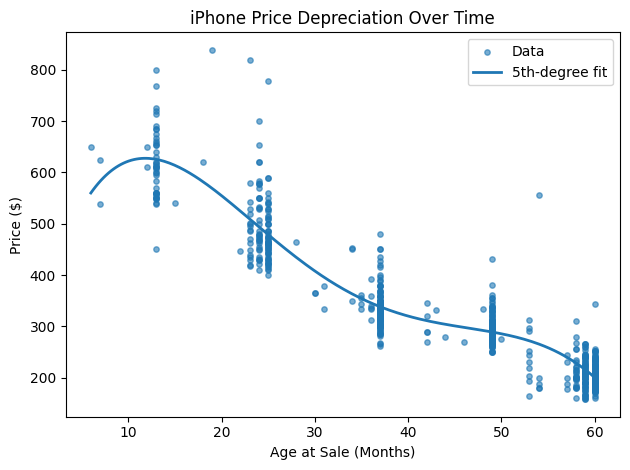

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# 1) Clean column names
data.rename(columns=str.strip, inplace=True)

# 2) Clean & coerce to numeric
# Age: keep the first number (handles "12", "12.5", "12 mo")
x = pd.to_numeric(
    data['Age_at_Sale'].astype(str).str.extract(r'([+-]?\d*\.?\d+)')[0],
    errors='coerce'
).to_numpy(dtype=float)

# Price: strip $ and commas then convert
y = pd.to_numeric(
    data['Price'].astype(str).str.replace(r'[$,]', '', regex=True),
    errors='coerce'
).to_numpy(dtype=float)

# 3) Mask invalids after coercion
m = np.isfinite(x) & np.isfinite(y)
x = x[m]
y = y[m]

# 4) Optional: guard against empty/too-small data
if x.size < 6:
    raise ValueError(f"Not enough clean points for a 5th-degree fit (got {x.size}).")

# 5) Fit & plot
coeffs = np.polyfit(x, y, 3)  # consider lower degree to avoid overfit
poly_eq = np.poly1d(coeffs)

x_line = np.linspace(x.min(), x.max(), 200)
y_line = poly_eq(x_line)

plt.scatter(x, y, s=15, alpha=0.6, label='Data')
plt.plot(x_line, y_line, linewidth=2, label='5th-degree fit')
plt.xlabel('Age at Sale (Months)')
plt.ylabel('Price ($)')
plt.title('iPhone Price Depreciation Over Time')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Map first release price for iPhone models (12,13,14,15,16,17) by storage capacity\n
import re
import numpy as np
import pandas as pd

# Prices (U.S. launch prices) by model and storage\n
# Keys are model numbers as strings to make matching simple
release_price_map = {
    '12': { '64': 799.0, '128': 849.0, '256': 949.0 },
    '13': { '128': 799.0, '256': 899.0, '512': 1099.0 },
    '14': { '128': 799.0, '256': 899.0, '512': 1099.0 },
    '15': { '128': 799.0, '256': 899.0, '512': 1099.0 },
    '16': { '128': 799.0, '256': 899.0, '512': 1099.0 },
    '17': { '256': 799.0, '512': 999.0 },
}

# Function to extract storage from common columns or fallback to Title parsing\n
def extract_storage_from_row(row):
    # Try common explicit columns first (if they exist)\n
    for col in ['Storage', 'Capacity', 'Memory', 'Storage Capacity']:
        if col in row.index and pd.notna(row[col]):
            s = str(row[col])
            m = re.search(r'(64|128|256|512)', s)
            if m:
                return m.group(1)
    # Fallback: parse Title\n
    title = str(row.get('Title', ''))
    m = re.search(r'\b(64|128|256|512)\s*(?:GB|G|gb)?\b', title, flags=re.IGNORECASE)
    if m:
        return m.group(1)
    # Try compact forms like '64GB' without space
    m = re.search(r'(64|128|256|512)GB', title, flags=re.IGNORECASE)
    if m:
        return m.group(1)
    return None

# Helper to get model number (e.g., '12', '13') from Model or Title fields\n
def extract_model_number(row):
    # Check Model column first
    model_field = str(row.get('Model', ''))
    # match 'iPhone' followed by optional spaces and a 1- or 2-digit number (e.g. '12', '16')
    m = re.search(r'iphone\s*([0-9]{1,2})', model_field, flags=re.IGNORECASE)
    if m:
        return m.group(1)
    # Fallback to Title
    title = str(row.get('Title', ''))
    m = re.search(r'iphone\s*([0-9]{1,2})', title, flags=re.IGNORECASE)
    if m:
        return m.group(1)
    return None

# Mapper that assigns the release price if we have a mapping for that model+storage\n
def map_first_release_price(row):
    model_num = extract_model_number(row)
    if not model_num:
        return np.nan
    model_num = model_num.strip()
    if model_num not in release_price_map:
        return np.nan
    storage = extract_storage_from_row(row)
    if storage and storage in release_price_map[model_num]:
        return release_price_map[model_num][storage]
    return np.nan

# Apply mapping to the DataFrame named `data` (already created earlier in the notebook)\n
# If `data` is not in memory, re-load from the CSV generated earlier: 'iPhone_base.csv'\n
if 'data' not in globals():
    try:
        data = pd.read_csv('iPhone_base.csv')
        data['Sold Date'] = pd.to_datetime(data['Sold Date'], errors='coerce')
    except FileNotFoundError:
        raise FileNotFoundError('iPhone_base.csv not found; run earlier cells to produce `data`')

# Create/overwrite the column
data['First_Release_Price'] = data.apply(map_first_release_price, axis=1)

# Quick checks: report filled counts per model
for model_num, mapping in release_price_map.items():
    model_label = f'iPhone {model_num}'
    total = data[data['Model'].str.contains(model_label, case=False, na=False)].shape[0]
    filled = data[(data['Model'].str.contains(model_label, case=False, na=False)) & (data['First_Release_Price'].notna())].shape[0]
    print(f'{model_label}: filled {filled} / {total}')

# Show sample rows where price was set
display(data[data['First_Release_Price'].notna()].head())

# Optionally save an updated CSV (uncomment to write)\n
# data.to_csv('iPhone_base_with_release_price.csv', index=False)
data


iPhone 12: filled 237 / 242
iPhone 13: filled 118 / 120
iPhone 14: filled 141 / 141
iPhone 15: filled 118 / 119
iPhone 16: filled 44 / 46
iPhone 17: filled 0 / 0


,Page,Title,Price,Sold Date,Link,Image Link,Storage,Condition,PartsOnly,Model,iPhone_12,iPhone_13,iPhone_14,iPhone_15,iPhone_16,Release Date,Age_at_Sale,Release Date (Year-Month),First_Release_Price
0,1,Very Good Apple iPhone 12 64GB Unlocked- 1 Yr...,$187.87,2025-10-22,https://www.ebay.com/itm/335986102571,https://i.ebayimg.com/images/g/zKIAAOSweCloU5X...,64 GB,Very Good,False,iPhone 12,True,NaN,NaN,NaN,NaN,2020-10-01,60.0,2020-10,799.0
1,1,Apple iPhone 12 Purple 128GB Good - Refurbishe...,$210.99,2025-10-22,https://www.ebay.com/itm/127185353194,https://i.ebayimg.com/images/g/BYYAAeSwZslo-Uq...,128 GB,Good,False,iPhone 12,True,NaN,NaN,NaN,NaN,2020-10-01,60.0,2020-10,849.0
2,1,Apple iPhone 12 64GB – Fully Unlocked - VERY G...,$191.99,2025-10-22,https://www.ebay.com/itm/325852789181,https://i.ebayimg.com/images/g/obAAAOSw2IplMD~...,64 GB,Very Good,False,iPhone 12,True,NaN,NaN,NaN,NaN,2020-10-01,60.0,2020-10,799.0
3,1,Apple iPhone 12 128GB - Fully Unlocked - VERY ...,$219.99,2025-10-22,https://www.ebay.com/itm/225936656368,https://i.ebayimg.com/images/g/1AIAAOSwNpxn5Jn...,128 GB,Very Good,False,iPhone 12,True,NaN,NaN,NaN,NaN,2020-10-01,60.0,2020-10,849.0
4,1,Apple iPhone 12 Black 64GB Excellent - Refurbi...,$200.99,2025-09-15,https://www.ebay.com/itm/127264771152,https://i.ebayimg.com/images/g/QboAAeSwUnVoyEZ...,64 GB,Excellent,False,iPhone 12,True,NaN,NaN,NaN,NaN,2020-10-01,59.0,2020-10,799.0


,Page,Title,Price,Sold Date,Link,Image Link,Storage,Condition,PartsOnly,Model,iPhone_12,iPhone_13,iPhone_14,iPhone_15,iPhone_16,Release Date,Age_at_Sale,Release Date (Year-Month),First_Release_Price
0,1,Very Good Apple iPhone 12 64GB Unlocked- 1 Yr...,$187.87,2025-10-22,https://www.ebay.com/itm/335986102571,https://i.ebayimg.com/images/g/zKIAAOSweCloU5X...,64 GB,Very Good,False,iPhone 12,True,NaN,NaN,NaN,NaN,2020-10-01,60.0,2020-10,799.0
1,1,Apple iPhone 12 Purple 128GB Good - Refurbishe...,$210.99,2025-10-22,https://www.ebay.com/itm/127185353194,https://i.ebayimg.com/images/g/BYYAAeSwZslo-Uq...,128 GB,Good,False,iPhone 12,True,NaN,NaN,NaN,NaN,2020-10-01,60.0,2020-10,849.0
2,1,Apple iPhone 12 64GB – Fully Unlocked - VERY G...,$191.99,2025-10-22,https://www.ebay.com/itm/325852789181,https://i.ebayimg.com/images/g/obAAAOSw2IplMD~...,64 GB,Very Good,False,iPhone 12,True,NaN,NaN,NaN,NaN,2020-10-01,60.0,2020-10,799.0
3,1,Apple iPhone 12 128GB - Fully Unlocked - VERY ...,$219.99,2025-10-22,https://www.ebay.com/itm/225936656368,https://i.ebayimg.com/images/g/1AIAAOSwNpxn5Jn...,128 GB,Very Good,False,iPhone 12,True,NaN,NaN,NaN,NaN,2020-10-01,60.0,2020-10,849.0
4,1,Apple iPhone 12 Black 64GB Excellent - Refurbi...,$200.99,2025-09-15,https://www.ebay.com/itm/127264771152,https://i.ebayimg.com/images/g/QboAAeSwUnVoyEZ...,64 GB,Excellent,False,iPhone 12,True,NaN,NaN,NaN,NaN,2020-10-01,59.0,2020-10,799.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,3,Apple iPhone 16 - A3081 - Unlocked - Very Good,$559.99,2025-10-01,https://www.ebay.com/itm/277377058582,https://i.ebayimg.com/images/g/zJMAAeSwal5ow0D...,Unknown,Very Good,False,iPhone 16,NaN,NaN,NaN,NaN,True,2024-09-01,13.0,2024-09,NaN
664,3,Unlocked Apple iPhone 16 – 128GB – Pink – MYAR...,$624.99,2025-04-02,https://www.ebay.com/itm/176972890638,https://i.ebayimg.com/images/g/xg8AAOSwGd9n7AV...,128 GB,Unknown,False,iPhone 16,NaN,NaN,NaN,NaN,True,2024-09-01,7.0,2024-09,799.0
665,3,Apple iPhone 16 - 128GB - Black (Unlocked) A32...,$649.00,2025-09-30,https://www.ebay.com/itm/257125690355,https://i.ebayimg.com/images/g/V9kAAeSwBoto1vM...,128 GB,Excellent,False,iPhone 16,NaN,NaN,NaN,NaN,True,2024-09-01,12.0,2024-09,799.0
666,3,Apple iPhone 16 A3081 Unlocked 128GB Ultramari...,$609.99,2025-09-30,https://www.ebay.com/itm/196813463164,https://i.ebayimg.com/images/g/GQgAAOSwMUxnNqq...,128 GB,Very Good,False,iPhone 16,NaN,NaN,NaN,NaN,True,2024-09-01,12.0,2024-09,799.0


In [ ]:
import re
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from packaging import version
import sklearn

# 0) Hygiene
data = data.rename(columns=str.strip).copy()
data['Sold Date'] = pd.to_datetime(data['Sold Date'], errors='coerce')

# 1) Age_at_Sale (months) — months since publish/release
if 'Age_at_Sale' not in data.columns:
    data['Release Date'] = pd.to_datetime(data.get('Release Date'), errors='coerce')
    data['Age_at_Sale'] = (data['Sold Date'] - data['Release Date']).dt.days / 30.44

# 2) Clean numeric price columns early
def _clean_money(s):
    return pd.to_numeric(pd.Series(s, dtype="object").astype(str).str.replace(r'[$,]', '', regex=True),
                         errors='coerce')

data['Price_clean'] = _clean_money(data['Price'])
data['First_Release_Price_clean'] = _clean_money(data['First_Release_Price'])

# 3) Mask valid rows
mask = (
    data['Age_at_Sale'].notna() &
    data['Price_clean'].notna() &
    data['First_Release_Price_clean'].notna() &
    (data['First_Release_Price_clean'] > 0) &
    data['Sold Date'].notna()
)
df = data.loc[mask].copy()

# 4) Target: normalized price (ratio of launch price)
df['Price_ratio'] = df['Price_clean'] / df['First_Release_Price_clean']

# 5) Storage numeric from 'Storage' or fallback 'Title'
if 'Storage' in df.columns:
    storage_src = df['Storage'].astype(str)
else:
    storage_src = df.get('Title', pd.Series(index=df.index, dtype=str)).astype(str)

df['Storage_num'] = pd.to_numeric(storage_src.str.extract(r'(\d+)', expand=False), errors='coerce')

# 6) Condition cleanup — keep only Good / Very Good / Excellent; drop Fair & unknowns
df['Condition'] = df.get('Condition', pd.Series(index=df.index, dtype=object)).astype(str).str.strip().str.title()

# values to remove entirely
remove_conditions = {'Fair', 'Unknown', 'Unspecified', 'Na', 'Nan', 'None', ''}
df = df.loc[~df['Condition'].isin(remove_conditions)].copy()

# enforce allowed set and order (Good as baseline)
allowed_conditions = ['Good', 'Very Good', 'Excellent']
df = df.loc[df['Condition'].isin(allowed_conditions)].copy()
# Make it a Categorical to ensure stable ordering
df['Condition'] = pd.Categorical(df['Condition'], categories=allowed_conditions, ordered=True)

# 7) OneHotEncoder for Condition (version-safe) with Good as baseline (dropped)
skver = version.parse(sklearn.__version__)
if skver >= version.parse("1.2"):
    enc = OneHotEncoder(
        categories=[allowed_conditions],      # one feature: Condition
        drop=['Good'],                        # drop baseline category
        sparse_output=False,
        handle_unknown='ignore'
    )
else:
    enc = OneHotEncoder(
        categories=[allowed_conditions],
        drop=['Good'],
        sparse=False,
        handle_unknown='ignore'
    )

cond_mat  = enc.fit_transform(df[['Condition']])
# With Good dropped, resulting columns will be: ['Condition_Very Good', 'Condition_Excellent']
cond_cols = enc.get_feature_names_out(['Condition'])
cond_df   = pd.DataFrame(cond_mat, columns=cond_cols, index=df.index)



# 7) OneHotEncoder for Condition (version-safe)
skver = version.parse(sklearn.__version__)
if skver >= version.parse("1.2"):
    enc = OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore')
else:
    enc = OneHotEncoder(drop=None, sparse=False, handle_unknown='ignore')

cond_mat  = enc.fit_transform(df[['Condition']])
cond_cols = enc.get_feature_names_out(['Condition'])
cond_df   = pd.DataFrame(cond_mat, columns=cond_cols, index=df.index)

# 8) Assemble X/y with ONLY Age_at_Sale, Storage_num, and Condition dummies
X_num = df[['Age_at_Sale', 'Storage_num']].apply(pd.to_numeric, errors='coerce')
X = pd.concat([X_num, cond_df], axis=1)
y = pd.to_numeric(df['Price_ratio'], errors='coerce')

good = X.notna().all(axis=1) & y.notna()
X = X.loc[good]
y = y.loc[good]

if len(y) < 10:
    raise ValueError(f"Too few clean samples to train (got {len(y)}). "
                     "Ensure Age_at_Sale, Price, First_Release_Price, Storage, and Condition are present/clean.")

# 9) Fit
model = LinearRegression()
model.fit(X, y)

print("=== Model Fit (Age, Storage, Condition only) ===")
print("Samples used:", len(y))
print("Intercept:", model.intercept_)
print("Top coefficients (by magnitude):")
coef_series = pd.Series(model.coef_, index=X.columns).abs().sort_values(ascending=False).head(10)
for name in coef_series.index:
    print(f"  {name}: {model.coef_[X.columns.get_loc(name)]:.6f}")

# 10) Predictor — now without year/month of sale
def predict_price(age_months, storage_gb, condition, launch_price):
    base = pd.DataFrame({
        'Age_at_Sale': [float(age_months)],
        'Storage_num': [float(storage_gb)],
        'Condition': [str(condition).strip().title()]
    })
    cond_new = pd.DataFrame(enc.transform(base[['Condition']]), columns=cond_cols, index=base.index)
    X_new = pd.concat([base[['Age_at_Sale','Storage_num']], cond_new], axis=1)
    X_new = X_new.reindex(columns=X.columns, fill_value=0)
    ratio = float(model.predict(X_new))
    return ratio * float(launch_price)

# Example:
# price_usd = predict_price(age_months=18, storage_gb=256, condition='Excellent', launch_price=899)
# print(f"Predicted resale: ${price_usd:.2f}")


=== Model Fit (Age, Storage, Condition only) ===
Samples used: 531
Intercept: 0.8086272393429501
Top coefficients (by magnitude):
  Condition_Excellent: 0.023186
  Condition_Good: -0.020300
  Age_at_Sale: -0.009276
  Condition_Very Good: -0.002887
  Storage_num: -0.000099


In [ ]:
import re
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from packaging import version
import sklearn

# ----------------------------
# CONFIG
# ----------------------------
ALLOWED_STORAGE = [64, 128, 256, 512]               # keep all
ALLOWED_CONDITIONS = ['Good', 'Very Good', 'Excellent']
CONDITION_BASELINE = 'Good'                         # keep Good as baseline for cleaner condition effects

# ----------------------------
# INPUT: assume `data` DataFrame exists with at least:
# - 'Sold Date', 'Release Date' (if Age_at_Sale not present),
# - 'Price', 'First_Release_Price',
# - 'Storage' (or storage embedded in 'Title'),
# - 'Condition'
# ----------------------------

# 0) Hygiene
data = data.rename(columns=str.strip).copy()
data['Sold Date'] = pd.to_datetime(data['Sold Date'], errors='coerce')

# 1) Age_at_Sale (months) — months since publish/release
if 'Age_at_Sale' not in data.columns:
    data['Release Date'] = pd.to_datetime(data.get('Release Date'), errors='coerce')
    data['Age_at_Sale'] = (data['Sold Date'] - data['Release Date']).dt.days / 30.44

# 2) Clean numeric money columns early
def _clean_money(s):
    return pd.to_numeric(
        pd.Series(s, dtype="object").astype(str).str.replace(r'[$,]', '', regex=True),
        errors='coerce'
    )

data['Price_clean'] = _clean_money(data['Price'])
data['First_Release_Price_clean'] = _clean_money(data['First_Release_Price'])

# 3) Filter to valid rows for training
mask = (
    data['Age_at_Sale'].notna() &
    data['Price_clean'].notna() &
    data['First_Release_Price_clean'].notna() &
    (data['First_Release_Price_clean'] > 0) &
    data['Sold Date'].notna()
)
df = data.loc[mask].copy()

# 4) Target: normalized price (ratio of launch price)
df['Price_ratio'] = df['Price_clean'] / df['First_Release_Price_clean']

# 5) Storage parsing → keep only allowed sizes (categorical)
if 'Storage' in df.columns:
    storage_src = df['Storage'].astype(str)
else:
    storage_src = df.get('Title', pd.Series(index=df.index, dtype=str)).astype(str)

df['Storage_num'] = pd.to_numeric(storage_src.str.extract(r'(\d+)', expand=False), errors='coerce')
df = df.loc[df['Storage_num'].isin(ALLOWED_STORAGE)].copy()
df['Storage_num'] = df['Storage_num'].astype(int)

# 6) Condition cleanup — keep only Good / Very Good / Excellent; drop Fair & unknowns
df['Condition'] = df.get('Condition', pd.Series(index=df.index, dtype=object)).astype(str).str.strip().str.title()
remove_conditions = {'Fair', 'Unknown', 'Unspecified', 'Na', 'Nan', 'None', ''}
df = df.loc[~df['Condition'].isin(remove_conditions)].copy()
df = df.loc[df['Condition'].isin(ALLOWED_CONDITIONS)].copy()
df['Condition'] = pd.Categorical(df['Condition'], categories=ALLOWED_CONDITIONS, ordered=True)

# 7) OneHotEncoders (version-safe)
skver = version.parse(sklearn.__version__)

# Condition encoder: drop Good as baseline
if skver >= version.parse("1.2"):
    enc_cond = OneHotEncoder(categories=[ALLOWED_CONDITIONS], drop=[CONDITION_BASELINE],
                             sparse_output=False, handle_unknown='ignore')
else:
    enc_cond = OneHotEncoder(categories=[ALLOWED_CONDITIONS], drop=[CONDITION_BASELINE],
                             sparse=False, handle_unknown='ignore')

cond_mat  = enc_cond.fit_transform(df[['Condition']])
cond_cols = enc_cond.get_feature_names_out(['Condition'])
cond_df   = pd.DataFrame(cond_mat, columns=cond_cols, index=df.index)

# Storage encoder: show ALL storages (NO baseline dropped) -> you will see Storage_num_128
if skver >= version.parse("1.2"):
    enc_sto = OneHotEncoder(categories=[ALLOWED_STORAGE], drop=None,
                            sparse_output=False, handle_unknown='ignore')
else:
    enc_sto = OneHotEncoder(categories=[ALLOWED_STORAGE], drop=None,
                            sparse=False, handle_unknown='ignore')

sto_mat  = enc_sto.fit_transform(df[['Storage_num']])
sto_cols = enc_sto.get_feature_names_out(['Storage_num'])
sto_df   = pd.DataFrame(sto_mat, columns=sto_cols, index=df.index)

# 8) Assemble X/y with Age_at_Sale (numeric) + Storage dummies (including 128) + Condition dummies
X = pd.concat([df[['Age_at_Sale']].apply(pd.to_numeric, errors='coerce'), sto_df, cond_df], axis=1)
y = pd.to_numeric(df['Price_ratio'], errors='coerce')

good = X.notna().all(axis=1) & y.notna()
X = X.loc[good]
y = y.loc[good]

if len(y) < 10:
    raise ValueError(
        f"Too few clean samples to train (got {len(y)}). "
        "Ensure Age_at_Sale, Price, First_Release_Price, Storage (64/128/256/512), and Condition are present/clean."
    )

# 9) Fit model
# NOTE: with all storage dummies and an intercept, the design matrix is rank-deficient.
# LinearRegression handles this with SVD; predictions are fine, individual storage coefs may not be unique.
model = LinearRegression()
model.fit(X, y)

# Keep column order for prediction alignment
X_COLUMNS = X.columns

# 10) Report
print("=== Model Fit (Age + categorical Storage (incl. 128) + Condition) ===")
print("Samples used:", len(y))
print("Intercept:", model.intercept_)
print("Top coefficients (by magnitude):")
coef_series = pd.Series(model.coef_, index=X.columns).abs().sort_values(ascending=False).head(12)
for name in coef_series.index:
    print(f"  {name}: {model.coef_[X.columns.get_loc(name)]:.6f}")

# 11) Predictor — storage must be one of ALLOWED_STORAGE; condition must be in ALLOWED_CONDITIONS
def predict_price(age_months, storage_gb, condition, launch_price):
    storage_gb = int(storage_gb)
    if storage_gb not in set(ALLOWED_STORAGE):
        raise ValueError(f"storage_gb must be one of {ALLOWED_STORAGE}; got {storage_gb}")
    condition = str(condition).strip().title()
    if condition not in set(ALLOWED_CONDITIONS):
        raise ValueError(f"condition must be one of {ALLOWED_CONDITIONS}; got {condition}")

    base = pd.DataFrame({
        'Age_at_Sale': [float(age_months)],
        'Storage_num': [storage_gb],
        'Condition': [condition]
    })

    # Dummies via fitted encoders
    cond_new = pd.DataFrame(enc_cond.transform(base[['Condition']]), columns=cond_cols, index=base.index)
    sto_new  = pd.DataFrame(enc_sto.transform(base[['Storage_num']]), columns=sto_cols, index=base.index)

    # Assemble features in training order
    X_new = pd.concat([base[['Age_at_Sale']], sto_new, cond_new], axis=1)
    X_new = X_new.reindex(columns=X_COLUMNS, fill_value=0)

    ratio = float(model.predict(X_new))
    return ratio * float(launch_price)

# ----------------------------
# Example:
# price_usd = predict_price(age_months=18, storage_gb=128, condition='Excellent', launch_price=899)
# print(f"Predicted resale: ${price_usd:.2f}")
# ----------------------------


=== Model Fit (Age + categorical Storage (incl. 128) + Condition) ===
Samples used: 531
Intercept: 0.7583930880690624
Top coefficients (by magnitude):
  Condition_Excellent: 0.043627
  Storage_num_512: -0.042611
  Condition_Very Good: 0.017841
  Storage_num_64: 0.015694
  Storage_num_128: 0.013851
  Storage_num_256: 0.013066
  Age_at_Sale: -0.009218


In [ ]:
import re
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from packaging import version
import sklearn

# ----------------------------
# CONFIG
# ----------------------------
ALLOWED_STORAGE = [64, 128, 256, 512]
ALLOWED_CONDITIONS = ['Good', 'Very Good', 'Excellent']
# NOTE: we no longer drop a baseline
CONDITION_BASELINE = None

# ----------------------------
# INPUT: assume `data` DataFrame exists
# ----------------------------

# 0) Hygiene
data = data.rename(columns=str.strip).copy()
data['Sold Date'] = pd.to_datetime(data['Sold Date'], errors='coerce')

# 1) Age_at_Sale
if 'Age_at_Sale' not in data.columns:
    data['Release Date'] = pd.to_datetime(data.get('Release Date'), errors='coerce')
    data['Age_at_Sale'] = (data['Sold Date'] - data['Release Date']).dt.days / 30.44

# 2) Clean numeric money columns
def _clean_money(s):
    return pd.to_numeric(
        pd.Series(s, dtype="object").astype(str).str.replace(r'[$,]', '', regex=True),
        errors='coerce'
    )

data['Price_clean'] = _clean_money(data['Price'])
data['First_Release_Price_clean'] = _clean_money(data['First_Release_Price'])

# 3) Filter valid rows
mask = (
    data['Age_at_Sale'].notna() &
    data['Price_clean'].notna() &
    data['First_Release_Price_clean'].notna() &
    (data['First_Release_Price_clean'] > 0) &
    data['Sold Date'].notna()
)
df = data.loc[mask].copy()

# 4) Target
df['Price_ratio'] = df['Price_clean'] / df['First_Release_Price_clean']

# 5) Storage
if 'Storage' in df.columns:
    storage_src = df['Storage'].astype(str)
else:
    storage_src = df.get('Title', pd.Series(index=df.index, dtype=str)).astype(str)

df['Storage_num'] = pd.to_numeric(storage_src.str.extract(r'(\d+)', expand=False), errors='coerce')
df = df.loc[df['Storage_num'].isin(ALLOWED_STORAGE)].copy()
df['Storage_num'] = df['Storage_num'].astype(int)

# 6) Condition
df['Condition'] = df.get('Condition', pd.Series(index=df.index, dtype=object)).astype(str).str.strip().str.title()
remove_conditions = {'Fair', 'Unknown', 'Unspecified', 'Na', 'Nan', 'None', ''}
df = df.loc[~df['Condition'].isin(remove_conditions)].copy()
df = df.loc[df['Condition'].isin(ALLOWED_CONDITIONS)].copy()
df['Condition'] = pd.Categorical(df['Condition'], categories=ALLOWED_CONDITIONS, ordered=True)

# 7) Encoders
skver = version.parse(sklearn.__version__)

# Condition encoder: keep all conditions
if skver >= version.parse("1.2"):
    enc_cond = OneHotEncoder(categories=[ALLOWED_CONDITIONS], drop=None,
                             sparse_output=False, handle_unknown='ignore')
else:
    enc_cond = OneHotEncoder(categories=[ALLOWED_CONDITIONS], drop=None,
                             sparse=False, handle_unknown='ignore')

cond_mat  = enc_cond.fit_transform(df[['Condition']])
cond_cols = enc_cond.get_feature_names_out(['Condition'])
cond_df   = pd.DataFrame(cond_mat, columns=cond_cols, index=df.index)

# Storage encoder: keep all
if skver >= version.parse("1.2"):
    enc_sto = OneHotEncoder(categories=[ALLOWED_STORAGE], drop=None,
                            sparse_output=False, handle_unknown='ignore')
else:
    enc_sto = OneHotEncoder(categories=[ALLOWED_STORAGE], drop=None,
                            sparse=False, handle_unknown='ignore')

sto_mat  = enc_sto.fit_transform(df[['Storage_num']])
sto_cols = enc_sto.get_feature_names_out(['Storage_num'])
sto_df   = pd.DataFrame(sto_mat, columns=sto_cols, index=df.index)

# 8) Assemble X/y
X = pd.concat([df[['Age_at_Sale']].apply(pd.to_numeric, errors='coerce'), sto_df, cond_df], axis=1)
y = pd.to_numeric(df['Price_ratio'], errors='coerce')

good = X.notna().all(axis=1) & y.notna()
X = X.loc[good]
y = y.loc[good]

if len(y) < 10:
    raise ValueError(f"Too few clean samples to train (got {len(y)}).")

# 9) Fit model
model = LinearRegression()
model.fit(X, y)
X_COLUMNS = X.columns

# 10) Report
print("=== Model Fit (Age + categorical Storage + Condition) ===")
print("Samples used:", len(y))
print("Intercept:", model.intercept_)
print("Top coefficients (by magnitude):")
coef_series = pd.Series(model.coef_, index=X.columns).abs().sort_values(ascending=False).head(12)
for name in coef_series.index:
    print(f"  {name}: {model.coef_[X.columns.get_loc(name)]:.6f}")

# 11) Predictor
def predict_price(age_months, storage_gb, condition, launch_price):
    storage_gb = int(storage_gb)
    if storage_gb not in set(ALLOWED_STORAGE):
        raise ValueError(f"storage_gb must be one of {ALLOWED_STORAGE}; got {storage_gb}")
    condition = str(condition).strip().title()
    if condition not in set(ALLOWED_CONDITIONS):
        raise ValueError(f"condition must be one of {ALLOWED_CONDITIONS}; got {condition}")

    base = pd.DataFrame({
        'Age_at_Sale': [float(age_months)],
        'Storage_num': [storage_gb],
        'Condition': [condition]
    })

    cond_new = pd.DataFrame(enc_cond.transform(base[['Condition']]), columns=cond_cols, index=base.index)
    sto_new  = pd.DataFrame(enc_sto.transform(base[['Storage_num']]), columns=sto_cols, index=base.index)
    X_new = pd.concat([base[['Age_at_Sale']], sto_new, cond_new], axis=1)
    X_new = X_new.reindex(columns=X_COLUMNS, fill_value=0)

    ratio = float(model.predict(X_new))
    return ratio * float(launch_price)

# Example:
# price_usd = predict_price(age_months=18, storage_gb=128, condition='Good', launch_price=899)
# print(f"Predicted resale: ${price_usd:.2f}")


=== Model Fit (Age + categorical Storage + Condition) ===
Samples used: 531
Intercept: 0.7788822747042836
Top coefficients (by magnitude):
  Storage_num_512: -0.042611
  Condition_Excellent: 0.023138
  Condition_Good: -0.020489
  Storage_num_64: 0.015694
  Storage_num_128: 0.013851
  Storage_num_256: 0.013066
  Age_at_Sale: -0.009218
  Condition_Very Good: -0.002649


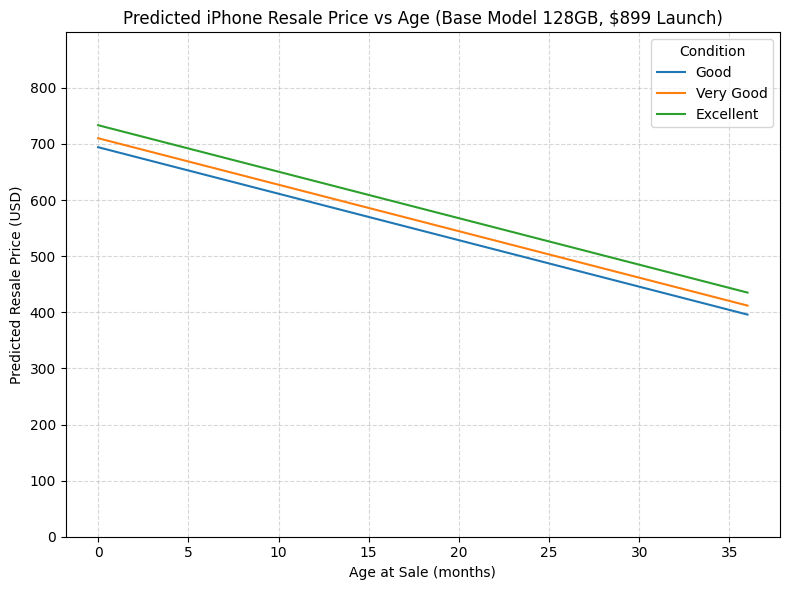

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Model coefficients from your fit
intercept = 0.7788822747042836
coefs = {
    "Storage_num_512": -0.042611,
    "Condition_Excellent": 0.023138,
    "Condition_Good": -0.020489,
    "Storage_num_64": 0.015694,
    "Storage_num_128": 0.013851,
    "Storage_num_256": 0.013066,
    "Age_at_Sale": -0.009218,
    "Condition_Very Good": -0.002649
}

# Settings for the base iPhone
launch_price = 899
storage = "Storage_num_128"

# Age range (0–36 months)
age_months = np.arange(0, 37)

# Predict resale ratio for each condition
def predict_ratio(age, condition):
    return (
        intercept
        + coefs["Age_at_Sale"] * age
        + coefs[storage]
        + coefs.get(f"Condition_{condition}", 0)
    )

conditions = ["Good", "Very Good", "Excellent"]
plt.figure(figsize=(8, 6))

for cond in conditions:
    ratio = predict_ratio(age_months, cond)
    price_usd = ratio * launch_price
    plt.plot(age_months, price_usd, label=cond)

plt.title("Predicted iPhone Resale Price vs Age (Base Model 128GB, $899 Launch)")
plt.xlabel("Age at Sale (months)")
plt.ylabel("Predicted Resale Price (USD)")
plt.ylim(0, launch_price)
plt.legend(title="Condition")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


=== Model Fit (Age + Age^2 + categorical Storage + Condition) ===
Samples used: 531
Intercept: 0.9141591907259464
Top coefficients (by magnitude):
  Storage_num_512: -0.036236
  Storage_num_128: 0.022671
  Condition_Excellent: 0.022158
  Condition_Good: -0.020246
  Storage_num_256: 0.019743
  Age_at_Sale: -0.018295
  Storage_num_64: -0.006177
  Condition_Very Good: -0.001912
  Age_at_Sale_Sq: 0.000121


/var/folders/g_/07970pkx1s139mt1t4qm27080000gn/T/ipykernel_23210/3583852638.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ratio = float(model.predict(X_new))
/var/folders/g_/07970pkx1s139mt1t4qm27080000gn/T/ipykernel_23210/3583852638.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ratio = float(model.predict(X_new))
/var/folders/g_/07970pkx1s139mt1t4qm27080000gn/T/ipykernel_23210/3583852638.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ratio = fl

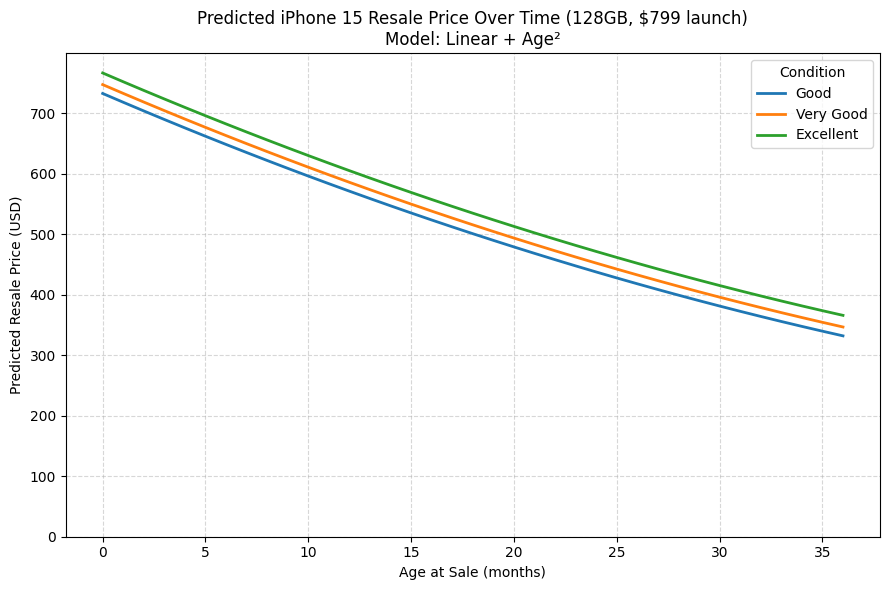

In [ ]:
# =========================
# Nonlinear age (quadratic)
# =========================

# 8) Assemble X/y with Age, Age^2, Storage dummies, Condition dummies
df['Age_at_Sale'] = pd.to_numeric(df['Age_at_Sale'], errors='coerce')
df['Age_at_Sale_Sq'] = df['Age_at_Sale'] ** 2

X = pd.concat([df[['Age_at_Sale', 'Age_at_Sale_Sq']], sto_df, cond_df], axis=1)
y = pd.to_numeric(df['Price_ratio'], errors='coerce')

good = X.notna().all(axis=1) & y.notna()
X = X.loc[good]
y = y.loc[good]

if len(y) < 10:
    raise ValueError(f"Too few clean samples to train (got {len(y)}).")

# 9) Fit model (same LinearRegression, now with extra curvature term)
model = LinearRegression()
model.fit(X, y)

# Keep column order for prediction alignment
X_COLUMNS = X.columns

# 10) Report
print("=== Model Fit (Age + Age^2 + categorical Storage + Condition) ===")
print("Samples used:", len(y))
print("Intercept:", model.intercept_)
coef_series = pd.Series(model.coef_, index=X.columns).sort_values(key=lambda s: s.abs(), ascending=False)
print("Top coefficients (by magnitude):")
for name in coef_series.head(12).index:
    print(f"  {name}: {model.coef_[X.columns.get_loc(name)]:.6f}")

# 11) Predictor — now includes Age^2
def predict_price(age_months, storage_gb, condition, launch_price):
    storage_gb = int(storage_gb)
    if storage_gb not in set(ALLOWED_STORAGE):
        raise ValueError(f"storage_gb must be one of {ALLOWED_STORAGE}; got {storage_gb}")
    condition = str(condition).strip().title()
    if condition not in set(ALLOWED_CONDITIONS):
        raise ValueError(f"condition must be one of {ALLOWED_CONDITIONS}; got {condition}")

    base = pd.DataFrame({
        'Age_at_Sale': [float(age_months)],
        'Age_at_Sale_Sq': [float(age_months) ** 2],
        'Storage_num': [storage_gb],
        'Condition': [condition]
    })

    # Dummies via fitted encoders (already fit)
    cond_new = pd.DataFrame(enc_cond.transform(base[['Condition']]), columns=cond_cols, index=base.index)
    sto_new  = pd.DataFrame(enc_sto.transform(base[['Storage_num']]), columns=sto_cols, index=base.index)

    # Assemble features in training order
    X_new = pd.concat([base[['Age_at_Sale', 'Age_at_Sale_Sq']], sto_new, cond_new], axis=1)
    X_new = X_new.reindex(columns=X_COLUMNS, fill_value=0)

    ratio = float(model.predict(X_new))
    return ratio * float(launch_price)

# =========================
# Plot: iPhone 15 (base) price over time with curvature
# =========================
import numpy as np
import matplotlib.pyplot as plt

# Config — adjust if needed
IPHONE15_LAUNCH_PRICE = 799      # USD (base model)
BASE_STORAGE_GB = 128            # base iPhone storage
AGE_RANGE = np.arange(0, 37)     # 0–36 months
CONDITIONS = ['Good', 'Very Good', 'Excellent']

plt.figure(figsize=(9, 6))
for cond in CONDITIONS:
    prices = [predict_price(a, BASE_STORAGE_GB, cond, IPHONE15_LAUNCH_PRICE) for a in AGE_RANGE]
    plt.plot(AGE_RANGE, prices, label=cond, linewidth=2)

plt.title("Predicted iPhone 15 Resale Price Over Time (128GB, $799 launch)\nModel: Linear + Age²")
plt.xlabel("Age at Sale (months)")
plt.ylabel("Predicted Resale Price (USD)")
plt.ylim(0, IPHONE15_LAUNCH_PRICE)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Condition")
plt.tight_layout()
plt.show()


/var/folders/g_/07970pkx1s139mt1t4qm27080000gn/T/ipykernel_23210/3583852638.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ratio = float(model.predict(X_new))
/var/folders/g_/07970pkx1s139mt1t4qm27080000gn/T/ipykernel_23210/3583852638.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ratio = float(model.predict(X_new))
/var/folders/g_/07970pkx1s139mt1t4qm27080000gn/T/ipykernel_23210/3583852638.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ratio = fl

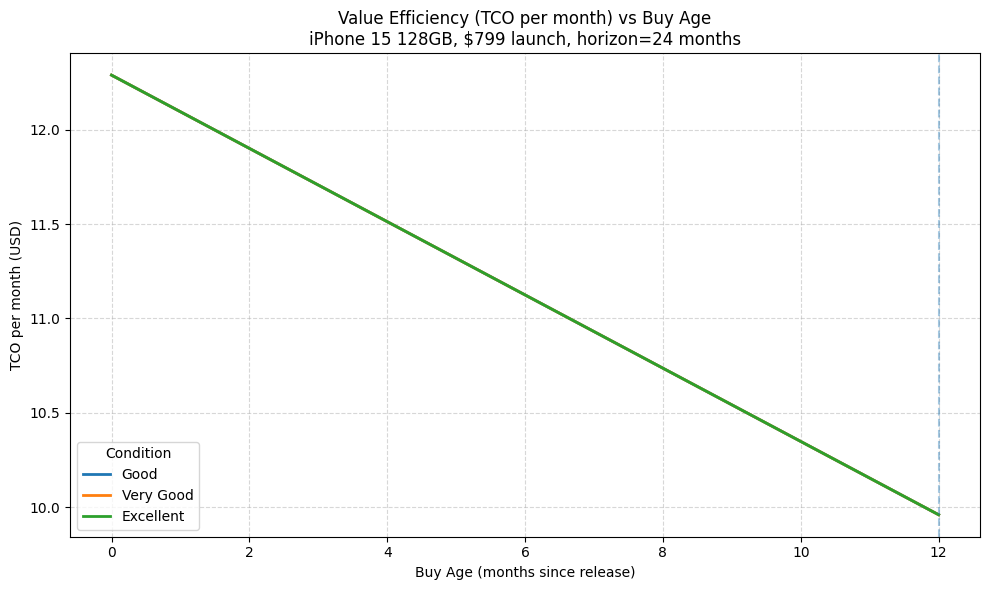

/var/folders/g_/07970pkx1s139mt1t4qm27080000gn/T/ipykernel_23210/3583852638.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ratio = float(model.predict(X_new))
/var/folders/g_/07970pkx1s139mt1t4qm27080000gn/T/ipykernel_23210/3583852638.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ratio = float(model.predict(X_new))
/var/folders/g_/07970pkx1s139mt1t4qm27080000gn/T/ipykernel_23210/3583852638.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ratio = fl

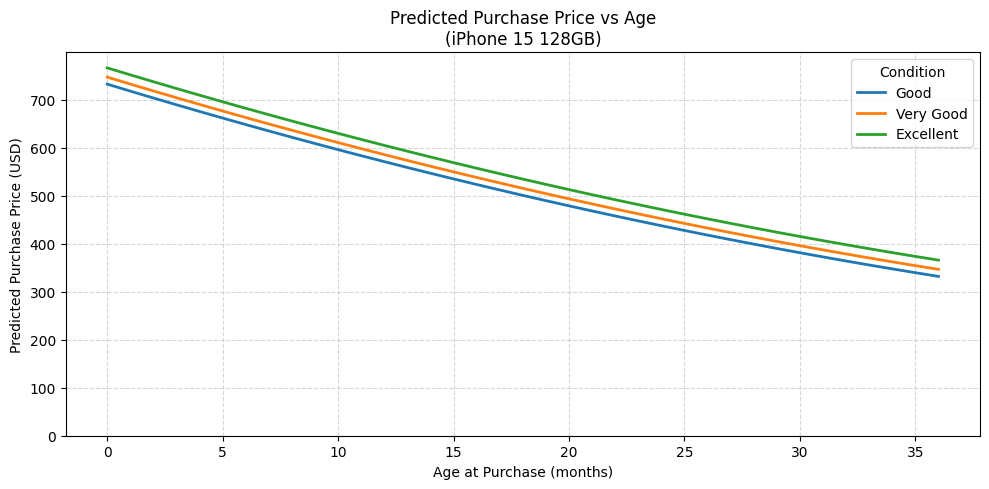

Best buy ages by condition (min TCO/month):
  Good       -> 12 months  (≈ $9.96/mo)
  Very Good  -> 12 months  (≈ $9.96/mo)
  Excellent  -> 12 months  (≈ $9.96/mo)

Overall best (by VE): Good at ~12 months (≈ $9.96/mo). Note: If your model is purely linear in age, VE will be flat; adding Age^2 (as shown earlier) makes the curve informative.


In [ ]:
# =========================
# iPhone 15 value/price graphs
# =========================
import numpy as np
import matplotlib.pyplot as plt

# ---- CONFIG ----
LAUNCH_PRICE = 799          # iPhone 15 (base) US launch price
STORAGE_GB = 128            # base storage
HORIZON_MONTHS = 24         # hold period after buying
AGE_MAX = 36                # only plot 0..36 months since release
CONDITIONS = ["Good", "Very Good", "Excellent"]

# ---- FALLBACK: linear model coefficients (used only if predict_price(...) is not defined) ----
# From your printed model:
_intercept = 0.7788822747042836
_coefs = {
    "Storage_num_64": 0.015694,
    "Storage_num_128": 0.013851,
    "Storage_num_256": 0.013066,
    "Storage_num_512": -0.042611,
    "Condition_Good": -0.020489,
    "Condition_Very Good": -0.002649,
    "Condition_Excellent": 0.023138,
    "Age_at_Sale": -0.009218,
}

def _predict_ratio_linear(age_mo, storage_gb, condition):
    storage_key = f"Storage_num_{int(storage_gb)}"
    return (
        _intercept
        + _coefs["Age_at_Sale"] * float(age_mo)
        + _coefs.get(storage_key, 0.0)
        + _coefs.get(f"Condition_{condition}", 0.0)
    )

def _predict_price_fallback(age_mo, storage_gb, condition, launch_price):
    return _predict_ratio_linear(age_mo, storage_gb, condition) * float(launch_price)

# Wrapper: prefer your trained model's predict_price(...); otherwise use fallback
def price_at(age_mo, cond, launch_price=LAUNCH_PRICE, storage_gb=STORAGE_GB):
    if "predict_price" in globals():
        return float(predict_price(age_months=float(age_mo),
                                   storage_gb=int(storage_gb),
                                   condition=cond,
                                   launch_price=float(launch_price)))
    else:
        return float(_predict_price_fallback(age_mo, storage_gb, cond, launch_price))

# ---- 1) Value Efficiency (TCO per month) vs Buy Age ----
# TCO(A, H) = Price(A) - Price(A+H);  VE(A) = TCO(A,H) / H
buy_ages = np.arange(0, AGE_MAX - HORIZON_MONTHS + 1)
plt.figure(figsize=(10, 6))
best_points = []

for cond in CONDITIONS:
    prices_now = np.array([price_at(a, cond) for a in buy_ages])
    prices_future = np.array([price_at(a + HORIZON_MONTHS, cond) for a in buy_ages])
    tco = prices_now - prices_future
    ve = tco / HORIZON_MONTHS

    plt.plot(buy_ages, ve, label=cond, linewidth=2)

    # Find minimum VE (cheapest cost per month) point
    idx = int(np.argmin(ve))
    best_points.append((cond, buy_ages[idx], ve[idx]))

# Optional: annotate overall best across conditions
overall = min(best_points, key=lambda x: x[2])
plt.axvline(overall[1], linestyle="--", alpha=0.4)
plt.title(f"Value Efficiency (TCO per month) vs Buy Age\n"
          f"iPhone 15 128GB, ${LAUNCH_PRICE} launch, horizon={HORIZON_MONTHS} months")
plt.xlabel("Buy Age (months since release)")
plt.ylabel("TCO per month (USD)")
plt.legend(title="Condition")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ---- 2) Predicted Purchase Price vs Age ----
ages_full = np.arange(0, AGE_MAX + 1)
plt.figure(figsize=(10, 5))
for cond in CONDITIONS:
    prices_curve = np.array([price_at(a, cond) for a in ages_full])
    plt.plot(ages_full, prices_curve, label=cond, linewidth=2)

plt.title("Predicted Purchase Price vs Age\n(iPhone 15 128GB)")
plt.xlabel("Age at Purchase (months)")
plt.ylabel("Predicted Purchase Price (USD)")
plt.ylim(0, LAUNCH_PRICE)
plt.legend(title="Condition")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Print the best-buy summary (per the VE metric)
print("Best buy ages by condition (min TCO/month):")
for cond, a, v in best_points:
    print(f"  {cond:<10} -> {a:2d} months  (≈ ${v:.2f}/mo)")

print(f"\nOverall best (by VE): {overall[0]} at ~{overall[1]} months "
      f"(≈ ${overall[2]:.2f}/mo). "
      "Note: If your model is purely linear in age, VE will be flat; "
      "adding Age^2 (as shown earlier) makes the curve informative.")
